In [1]:
import pandas as pd
import numpy as np
import scipy

from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery as bq

%matplotlib inline

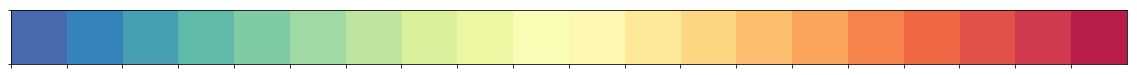

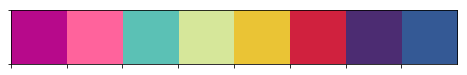

In [2]:
sns.palplot(sns.color_palette("Spectral_r", n_colors=20))
sns.palplot(sns.color_palette(["#b7098b","#ff639c", "#5bc1b5", "#d6e79a", "#eac435", "#d0213e", "#4c2c72", "#345995"]))

In [3]:
gene = pd.read_table("./datasets/correlated_gene_bigtable.tsv", sep="\t")

print(gene.shape)
gene.head()

(1899, 13)


gene_symbol       sig-DMD  corr_coef  p_value  abs_corr_coef  FDR_BH_Reject  \
0        AASS  sig-DMD_3915  -0.308366      0.0       0.308366           True   
1        AATF  sig-DMD_2188   0.369226      0.0       0.369226           True   
2       ABCA2  sig-DMD_4336  -0.357968      0.0       0.357968           True   
3       ABCA2  sig-DMD_4337   0.290721      0.0       0.290721           True   
4       ABCB5  sig-DMD_3809  -0.307431      0.0       0.307431           True   

   FDR_BH_p  Bonfer_Reject  Bonfer_p BRCA TN-BRCA nonTN-BRCA ERR-BRCA  
0       0.0           True       0.0  Yes     Yes        Yes       No  
1       0.0           True       0.0  Yes      No         No       No  
2       0.0           True       0.0  Yes     Yes        Yes       No  
3       0.0           True       0.0  Yes     Yes        Yes       No  
4       0.0           True       0.0  Yes      No         No       No

In [4]:
subtype_expression_bigtable = pd.read_table("./datasets/subtype_expression_bigtable.IlluminaHiSeq.corr_genes.tsv", 
                                            sep="\t")

print(subtype_expression_bigtable.shape)
subtype_expression_bigtable.head()

/home/singuyen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1544265, 16)


case_barcode    sample_barcode               aliquot_barcode gene_symbol  \
0  TCGA-3C-AAAU  TCGA-3C-AAAU-01A  TCGA-3C-AAAU-01A-11R-A41B-07        AASS   
1  TCGA-3C-AAAU  TCGA-3C-AAAU-01A  TCGA-3C-AAAU-01A-11R-A41B-07        AATF   
2  TCGA-3C-AAAU  TCGA-3C-AAAU-01A  TCGA-3C-AAAU-01A-11R-A41B-07       ABCA2   
3  TCGA-3C-AAAU  TCGA-3C-AAAU-01A  TCGA-3C-AAAU-01A-11R-A41B-07       ABCB5   
4  TCGA-3C-AAAU  TCGA-3C-AAAU-01A  TCGA-3C-AAAU-01A-11R-A41B-07       ABCG1   

   normalized_count  transformed_count  sample_type     sample_type_name  \
0           45.8396           5.549657            1  Primary solid Tumor   
1         1518.9114          10.569772            1  Primary solid Tumor   
2         4507.4481          12.138415            1  Primary solid Tumor   
3            0.3447           0.427284            1  Primary solid Tumor   
4         1020.1901           9.996036            1  Primary solid Tumor   

  subtype        ER        PR Her2_IHC Her2_ISH Her2 triple_negative  \
0    LumA  Positive  Positive      NaN      NaN  NaN         Unknown   
1    LumA  Positive  Positive      NaN      NaN  NaN         Unknown   
2    LumA  Positive  Positive      NaN      NaN  NaN         Unknown   
3    LumA  Positive  Positive      NaN      NaN  NaN         Unknown   
4    LumA  Positive  Positive      NaN      NaN  NaN         Unknown   

  subtype_sub  
0        LumA  
1        LumA  
2        LumA  
3        LumA  
4        LumA

In [5]:
print("Genes")
print(subtype_expression_bigtable.drop_duplicates(subset=["sample_barcode", 
                                                    "gene_symbol"]).gene_symbol.value_counts().describe())
print("\n")

brca_genes = list(gene.loc[gene['BRCA']=='Yes', 'gene_symbol'].unique())
trip_genes = list(gene.loc[gene['TN-BRCA']=='Yes', 'gene_symbol'].unique())
nontrip_genes = list(gene.loc[gene['nonTN-BRCA']=='Yes', 'gene_symbol'].unique())

print("BRCA genes")
print(len(subtype_expression_bigtable.loc[subtype_expression_bigtable['gene_symbol'].isin(brca_genes), 
                                          'gene_symbol'].unique()))
print("\n")

print("TN-BRCA genes")
print(len(subtype_expression_bigtable.loc[subtype_expression_bigtable['gene_symbol'].isin(trip_genes), 
                                          'gene_symbol'].unique()))
print("\n")

print("nonTN-BRCA genes")
print(len(subtype_expression_bigtable.loc[subtype_expression_bigtable['gene_symbol'].isin(nontrip_genes), 
                                          'gene_symbol'].unique()))
print("\n")

Genes
count    1271.0
mean     1215.0
std         0.0
min      1215.0
25%      1215.0
50%      1215.0
75%      1215.0
max      1215.0
Name: gene_symbol, dtype: float64


BRCA genes
922


TN-BRCA genes
472


nonTN-BRCA genes
582




In [6]:
df = subtype_expression_bigtable.drop_duplicates(subset="sample_barcode")

print("Sample types")
print(df.sample_type_name.value_counts())
print("\n")

print("BRCA subtypes")
print(df.loc[df['sample_type']==1].subtype_sub.value_counts())

Sample types
Primary solid Tumor    1095
Solid Tissue Normal     113
Metastatic                7
Name: sample_type_name, dtype: int64


BRCA subtypes
LumA        566
LumB        217
Basal       100
Basal-TN     90
Her2         82
Normal       40
Name: subtype_sub, dtype: int64


In [7]:
expression_matrix = subtype_expression_bigtable.pivot(index='gene_symbol', 
                                                      columns='aliquot_barcode', values='transformed_count')

print(expression_matrix.shape)
expression_matrix.head()

(1271, 1215)


aliquot_barcode  TCGA-3C-AAAU-01A-11R-A41B-07  TCGA-3C-AALI-01A-11R-A41B-07  \
gene_symbol                                                                   
AASS                                 5.549657                      6.185432   
AATF                                10.569772                     12.901294   
ABCA2                               12.138415                     11.186777   
ABCB5                                0.427284                      3.194812   
ABCG1                                9.996036                     10.195112   

aliquot_barcode  TCGA-3C-AALJ-01A-31R-A41B-07  TCGA-3C-AALK-01A-11R-A41B-07  \
gene_symbol                                                                   
AASS                                 6.269705                      7.525796   
AATF                                11.035428                     10.904020   
ABCA2                               11.648143                     10.426536   
ABCB5                                2.468088                      1.164271   
ABCG1                                9.196419                      9.011511   

aliquot_barcode  TCGA-4H-AAAK-01A-12R-A41B-07  TCGA-5L-AAT0-01A-12R-A41B-07  \
gene_symbol                                                                   
AASS                                 8.596031                      8.893473   
AATF                                10.362294                     10.174936   
ABCA2                                9.889099                     10.343339   
ABCB5                                0.511468                      2.779470   
ABCG1                               10.329749                      9.364487   

aliquot_barcode  TCGA-5L-AAT1-01A-12R-A41B-07  TCGA-5T-A9QA-01A-11R-A41B-07  \
gene_symbol                                                                   
AASS                                 8.360313                      7.188584   
AATF                                10.292855                     10.900933   
ABCA2                               10.334428                      9.570642   
ABCB5                                5.975898                      0.000000   
ABCG1                               10.231586                     10.546168   

aliquot_barcode  TCGA-A1-A0SB-01A-11R-A144-07  TCGA-A1-A0SD-01A-11R-A115-07  \
gene_symbol                                                                   
AASS                                 8.697004                      8.371397   
AATF                                 9.846231                     10.373893   
ABCA2                               10.707669                     10.182636   
ABCB5                                1.233581                      3.359395   
ABCG1                               12.128810                     11.693152   

aliquot_barcode              ...               TCGA-UL-AAZ6-01A-11R-A41B-07  \
gene_symbol                  ...                                              
AASS                         ...                                   4.495567   
AATF                         ...                                  10.375926   
ABCA2                        ...                                  10.627464   
ABCB5                        ...                                   0.846714   
ABCG1                        ...                                  10.702311   

aliquot_barcode  TCGA-UU-A93S-01A-21R-A41B-07  TCGA-V7-A7HQ-01A-11R-A33J-07  \
gene_symbol                                                                   
AASS                                 5.496299                      6.128743   
AATF                                 9.941978                     10.875037   
ABCA2                               10.315734                     10.887754   
ABCB5                                0.000000                      0.000000   
ABCG1                                7.606752                      9.388911   

aliquot_barcode  TCGA-W8-A86G-01A-21R-A36F-07  TCGA-WT-AB41-01A-11R-A41B-07  \
gene_symbol                                

In [8]:
labels_aliquots = {}

labels_aliquots["Normal"] = list(subtype_expression_bigtable.loc[subtype_expression_bigtable['sample_type'] == 11, 
                                                           'aliquot_barcode'].unique())

labels_aliquots["Metastasis"] = list(subtype_expression_bigtable.loc[subtype_expression_bigtable['sample_type'] == 6, 
                                                               'aliquot_barcode'].unique())

labels_aliquots["Luminal A"] = list(subtype_expression_bigtable.loc[(subtype_expression_bigtable['sample_type'] == 1) & 
                                                              (subtype_expression_bigtable['subtype_sub'] == 'LumA'), 
                                                              'aliquot_barcode'].unique())

labels_aliquots["Luminal B"] = list(subtype_expression_bigtable.loc[(subtype_expression_bigtable['sample_type'] == 1) & 
                                                              (subtype_expression_bigtable['subtype_sub'] == 'LumB'), 
                                                              'aliquot_barcode'].unique())

labels_aliquots["Triple negative"] = list(subtype_expression_bigtable.loc[(subtype_expression_bigtable['sample_type'] == 1) & 
                                                          (subtype_expression_bigtable['subtype_sub'] == 'Basal-TN'), 
                                                          'aliquot_barcode'].unique())

labels_aliquots["Basal"] = list(subtype_expression_bigtable.loc[(subtype_expression_bigtable['sample_type'] == 1) & 
                                                          (subtype_expression_bigtable['subtype_sub'] == 'Basal'), 
                                                          'aliquot_barcode'].unique())

labels_aliquots["Her2"] = list(subtype_expression_bigtable.loc[(subtype_expression_bigtable['sample_type'] == 1) & 
                                                         (subtype_expression_bigtable['subtype_sub']== 'Her2'), 
                                                         'aliquot_barcode'].unique())

labels_aliquots["Normal-like"] = list(subtype_expression_bigtable.loc[(subtype_expression_bigtable['sample_type'] == 1) & 
                                                                (subtype_expression_bigtable['subtype_sub'] == 'Normal'), 
                                                                'aliquot_barcode'].unique())

labels=[]
subtypes=[]
for k, v in labels_aliquots.items():
    print(len(v))
    labels.append(k)
    subtypes = subtypes + v

113
7
566
217
90
100
82
40


In [9]:
print(labels)

['Normal', 'Metastasis', 'Luminal A', 'Luminal B', 'Triple negative', 'Basal', 'Her2', 'Normal-like']


# All subtype-specific sig-DMDs

In [10]:
expression_matrix = expression_matrix.loc[:,subtypes]
sort_order = [item for key in ['Normal', 'Luminal A', 'Luminal B'] for item in labels_aliquots[key]]
expression_matrix.sort_values(by=sort_order, inplace=True)
expression_matrix.shape

(1271, 1215)

In [11]:
print(expression_matrix.min().min())
print(expression_matrix.max().max())

0.0
19.157613049838115


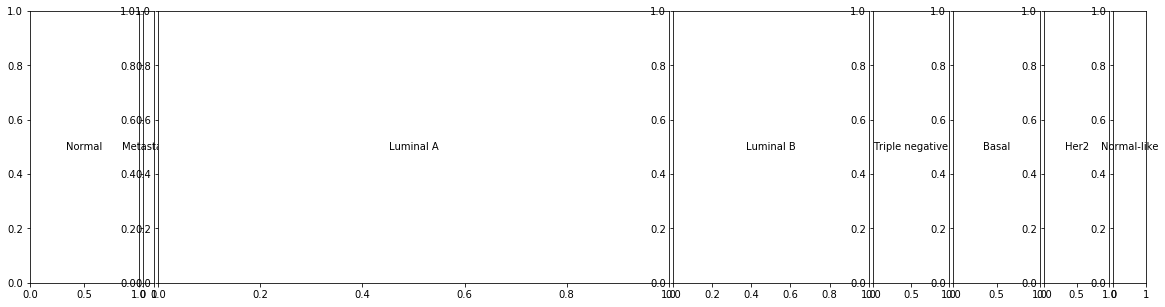

In [12]:
grid_kws = {"width_ratios": (0.1, 0.01, 0.47, 0.18, 0.07, 0.08, 0.06, 0.03), "wspace": 0.03}
fig, axes = plt.subplots(1, 8, figsize=(20,5), gridspec_kw=grid_kws)

for label, ax in zip(labels, axes):
    ax.text(0.5, 0.5, label, va="center", ha="center")

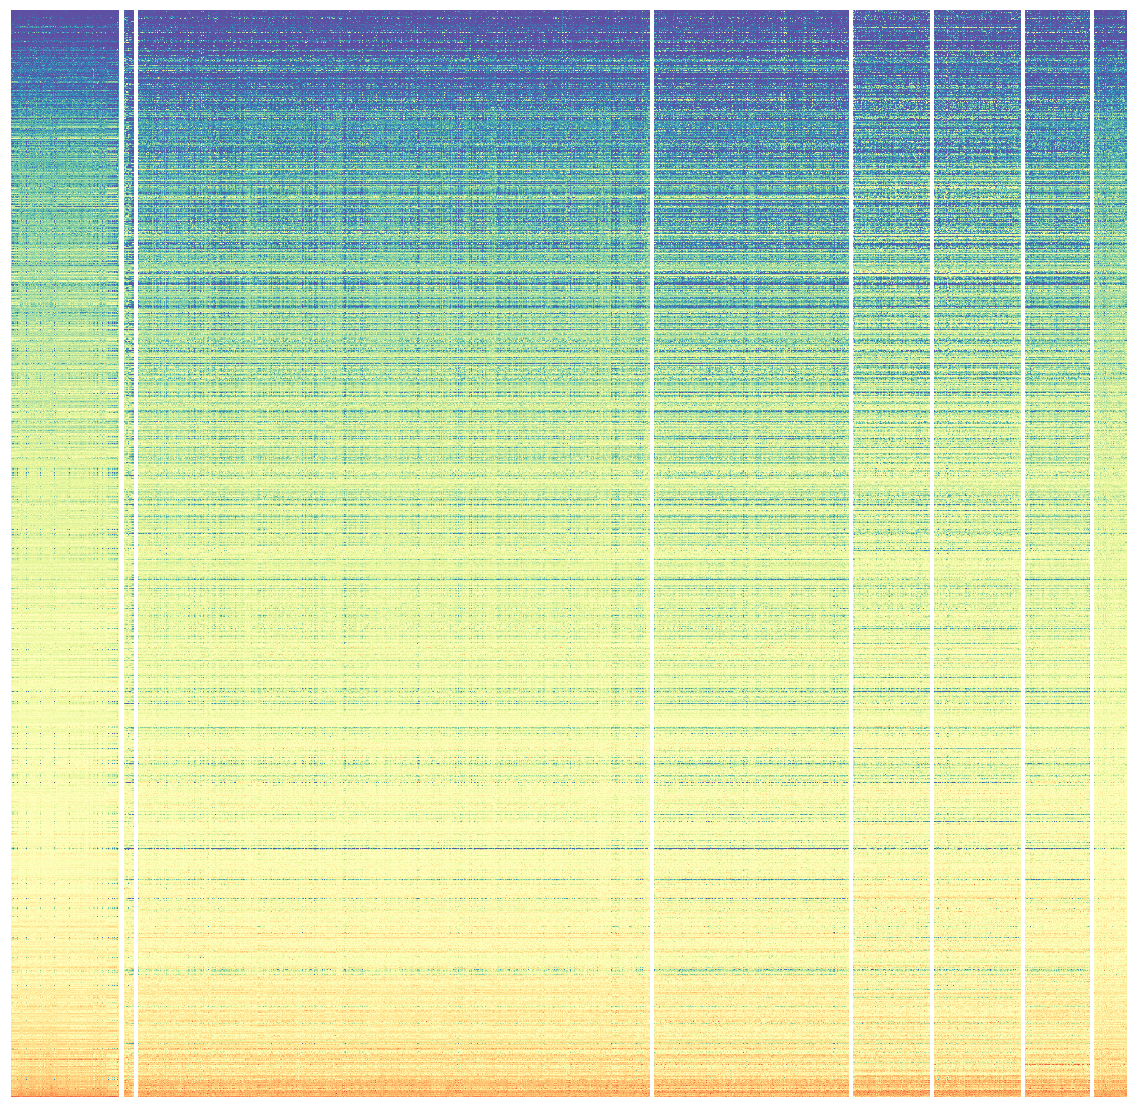

In [13]:
grid_kws = {"width_ratios": (0.1, 0.01, 0.47, 0.18, 0.07, 0.08, 0.06, 0.03), "wspace": 0.03}
fig, axes = plt.subplots(1, 8, figsize=(20,20), gridspec_kw=grid_kws)

for label, ax in zip(labels, axes):
    sns.heatmap(data=expression_matrix.loc[:, labels_aliquots[label]], 
                cmap="Spectral_r", vmin=0, vmax=21, 
                ax=ax, cbar=False,
                xticklabels=False, yticklabels=False)
    ax.set_ylabel('')    
    ax.set_xlabel('')

In [14]:
fig.savefig("./plots/expressiondata.subtype.png", bbox_inches = 'tight', transparent=True)

# BRCA signatures

In [10]:
expression_matrix = expression_matrix.loc[expression_matrix.index.intersection(brca_genes), 
                                          subtypes]
sort_order = [item for key in ['Normal', 'Luminal A', 'Luminal B'] for item in labels_aliquots[key]]
expression_matrix.sort_values(by=sort_order, inplace=True)
expression_matrix.shape

(922, 1215)

In [11]:
print(expression_matrix.min().min())
print(expression_matrix.max().max())

0.0
18.745815797688948


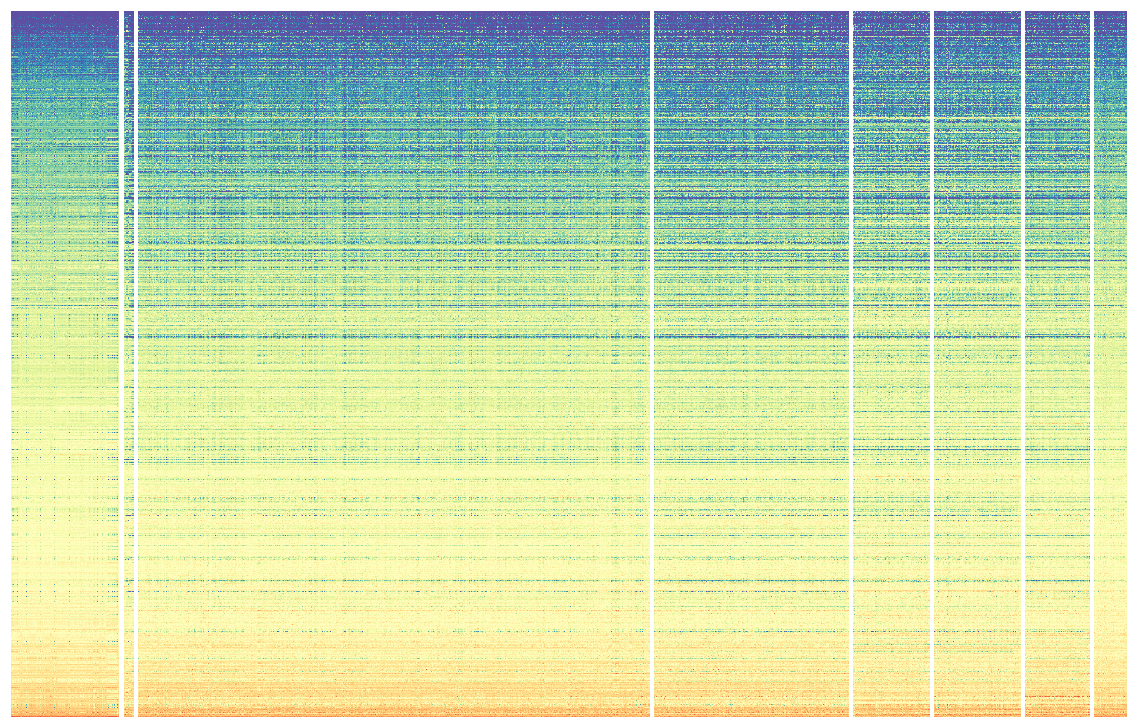

In [12]:
grid_kws = {"width_ratios": (0.1, 0.01, 0.47, 0.18, 0.07, 0.08, 0.06, 0.03), "wspace": 0.03}
fig, axes = plt.subplots(1, 8, figsize=(20,13), gridspec_kw=grid_kws)

for label, ax in zip(labels, axes):
    sns.heatmap(data=expression_matrix.loc[:, labels_aliquots[label]], 
                cmap="Spectral_r", vmin=0, vmax=21, 
                ax=ax, cbar=False, 
                xticklabels=False, yticklabels=False)
    ax.set_ylabel('')    
    ax.set_xlabel('')

In [13]:
fig.savefig("./plots/expressiondata.subtype.BRCAsigDMD.png", bbox_inches = 'tight', transparent=True)

# Tripple-negative (TN-BRCA) signatures

In [10]:
expression_matrix = expression_matrix.loc[expression_matrix.index.intersection(trip_genes), 
                                          subtypes]
sort_order = [item for key in ['Triple negative', 'Basal'] for item in labels_aliquots[key]]
expression_matrix.sort_values(by=sort_order, inplace=True)
expression_matrix.shape

(472, 1215)

In [11]:
print(expression_matrix.min().min())
print(expression_matrix.max().max())

0.0
19.157613049838115


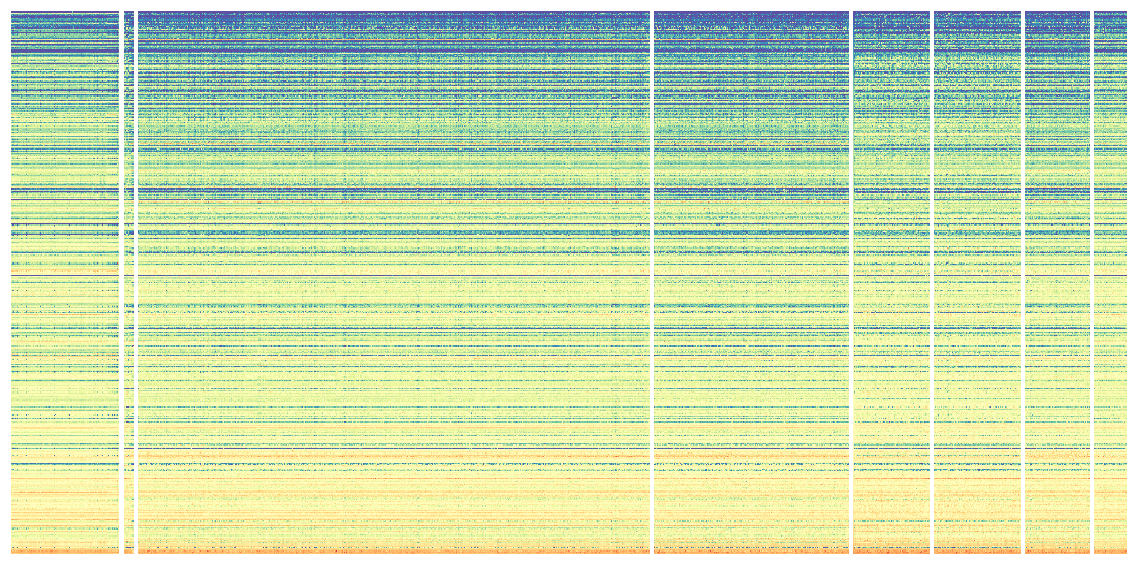

In [12]:
grid_kws = {"width_ratios": (0.1, 0.01, 0.47, 0.18, 0.07, 0.08, 0.06, 0.03), "wspace": 0.03}
fig, axes = plt.subplots(1, 8, figsize=(20,10), gridspec_kw=grid_kws)

for label, ax in zip(labels, axes):
    sns.heatmap(data=expression_matrix.loc[:, labels_aliquots[label]], 
                cmap="Spectral_r", vmin=0, vmax=21, 
                ax=ax, cbar=False, 
                xticklabels=False, yticklabels=False)
    ax.set_ylabel('')    
    ax.set_xlabel('')

In [13]:
fig.savefig("./plots/expressiondata.subtype.TNBRCAsigDMD.png", bbox_inches = 'tight', transparent=True)

# Non-Tripple-negative (nonTN-BRCA) signatures

In [10]:
expression_matrix = expression_matrix.loc[expression_matrix.index.intersection(nontrip_genes), 
                                          subtypes]
sort_order = [item for key in ['Luminal A', 'Luminal B'] for item in labels_aliquots[key]]
expression_matrix.sort_values(by=sort_order, inplace=True)
expression_matrix.shape

(582, 1215)

In [11]:
print(expression_matrix.min().min())
print(expression_matrix.max().max())

0.0
18.745815797688948


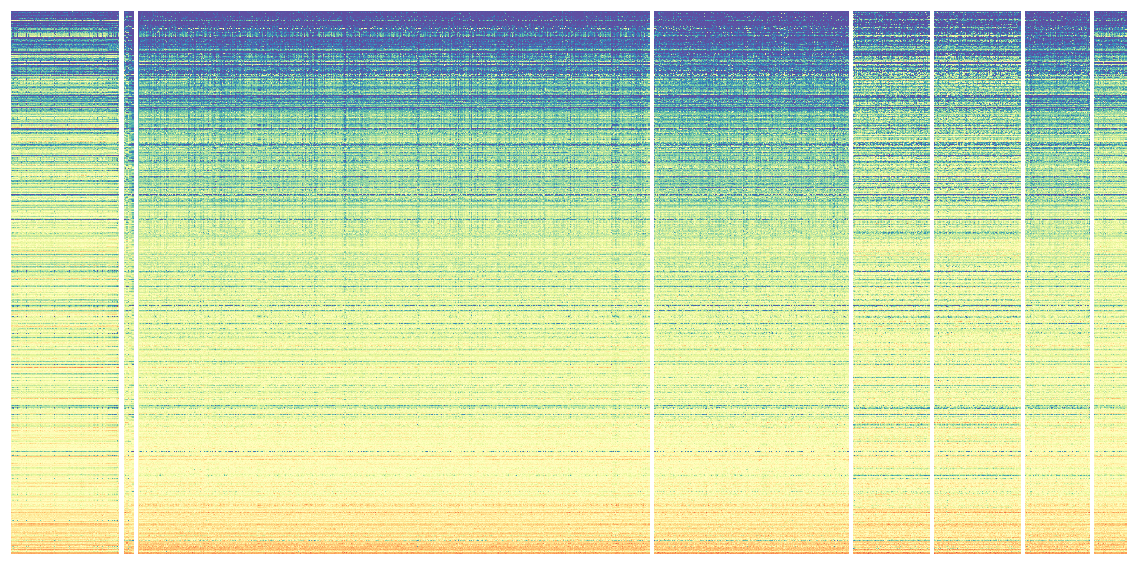

In [12]:
grid_kws = {"width_ratios": (0.1, 0.01, 0.47, 0.18, 0.07, 0.08, 0.06, 0.03), "wspace": 0.03}
fig, axes = plt.subplots(1, 8, figsize=(20,10), gridspec_kw=grid_kws)

for label, ax in zip(labels, axes):
    sns.heatmap(data=expression_matrix.loc[:, labels_aliquots[label]], 
                cmap="Spectral_r", vmin=0, vmax=21, 
                ax=ax, cbar=False, 
                xticklabels=False, yticklabels=False)
    ax.set_ylabel('')    
    ax.set_xlabel('')

In [13]:
fig.savefig("./plots/expressiondata.subtype.nonTNBRCAsigDMD.png", bbox_inches = 'tight', transparent=True)